In [2]:
!pip install pyTsetlinMachineParallel
!export OMP_NUM_THREADS=10

In [4]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from pyTsetlinMachineParallel.tm import MultiClassTsetlinMachine

# VGG-19 Block 1 + Tsetlin Machine for CIFAR-10 Dataset

This notebook implements only the first block of VGG-19 architecture followed by Tsetlin Machine to classify the CIFAR-10 dataset.

In [6]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Split training data to create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape labels to 1D arrays
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

print("Load Data Successfully")

print("\nDataset Shapes:")
print(f"Train: features {np.array(X_train).shape}, labels {np.array(y_train).shape}")
print(f"Val: features {np.array(X_val).shape}, labels {np.array(y_val).shape}")
print(f"Test: features {np.array(X_test).shape}, labels {np.array(y_test).shape}")

Load Data Successfully

Dataset Shapes:
Train: features (40000, 32, 32, 3), labels (40000,)
Val: features (10000, 32, 32, 3), labels (10000,)
Test: features (10000, 32, 32, 3), labels (10000,)


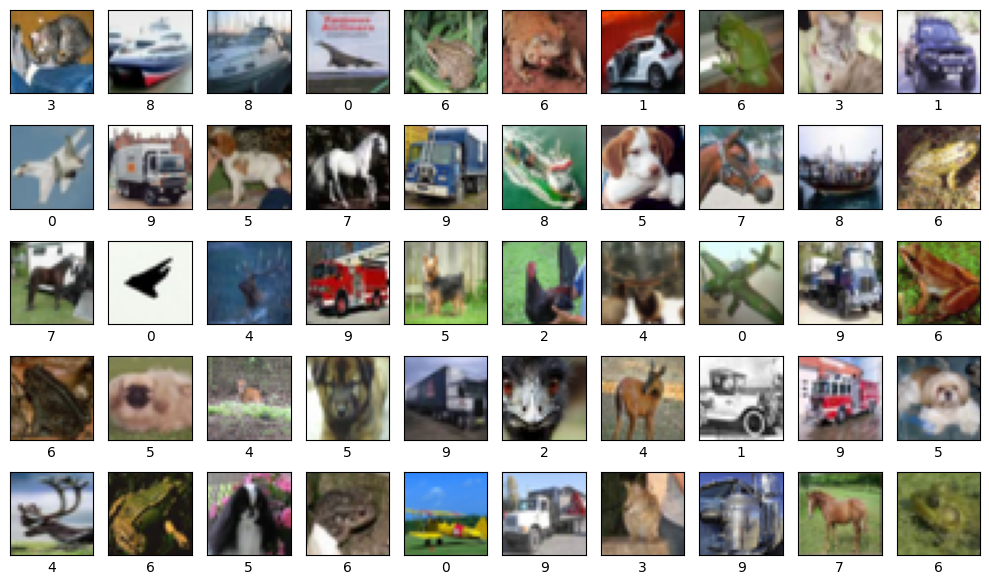

In [7]:
# Visualize some images from the dataset
plt.figure(figsize=(10,6))
for i in range(0,50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.xlabel(y_test[i])
plt.tight_layout()

In [8]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create a mapping from class index to class name
class_mapping = {i: name for i, name in enumerate(class_names)}
print(class_mapping)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [9]:
# Normalize images for CNN (pixel values from [0, 255] to [0, 1])
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

print(f"Input shape: {X_train_norm.shape[1:]}")
print(f"Data type: {X_train_norm.dtype}")
print(f"Value range: [{X_train_norm.min()}, {X_train_norm.max()}]")

Input shape: (32, 32, 3)
Data type: float64
Value range: [0.0, 1.0]


In [10]:
# Define VGG-19 architecture with only Block 1 for CIFAR-10
def build_vgg19_block1_model(input_shape=(32, 32, 3)):
    input_layer = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Flatten layer
    x = Flatten(name='flatten')(x)

    # Feature layer (for Tsetlin Machine)
    feature_layer = Dense(8192, activation='sigmoid', name='feature_layer')(x)

    # Output layer - Modified to have 10 neurons for CIFAR-10
    output_layer = Dense(10, activation='softmax', name='predictions')(feature_layer)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name='vgg19_block1')
    feature_extractor = Model(inputs=input_layer, outputs=feature_layer, name='feature_extractor')

    return model, feature_extractor

# Build the model
vgg19_block1_model, feature_extractor = build_vgg19_block1_model(input_shape=(32, 32, 3))

# Compile the model
vgg19_block1_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Print model summary
vgg19_block1_model.summary()

Model: "vgg19_block1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feature_layer (Dense)                │ (None, 8192)                │     134,225,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 10)                  │          81,930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,346,570 (512.49 MB)

 Trainable params: 134,346,570 (512.49 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('vgg19_block1_cifar10_best.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
print("\nTraining VGG-19 Block 1 model...")
batch_size = 32
epochs = 100

history = vgg19_block1_model.fit(
    X_train_norm, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_norm, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


Training VGG-19 Block 1 model...
Epoch 1/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2385 - loss: 2.4640

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - accuracy: 0.2387 - loss: 2.4631 - val_accuracy: 0.4920 - val_loss: 1.4368 - learning_rate: 0.0010
Epoch 2/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5174 - loss: 1.3582

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 58ms/step - accuracy: 0.5174 - loss: 1.3581 - val_accuracy: 0.5740 - val_loss: 1.2021 - learning_rate: 0.0010
Epoch 3/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6168 - loss: 1.0754

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 46ms/step - accuracy: 0.6168 - loss: 1.0754 - val_accuracy: 0.6444 - val_loss: 1.0208 - learning_rate: 0.0010
Epoch 4/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7086 - loss: 0.8203

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.7086 - loss: 0.8203 - val_accuracy: 0.6670 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 5/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8111 - loss: 0.5469

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 49ms/step - accuracy: 0.8110 - loss: 0.5469 - val_accuracy: 0.6728 - val_loss: 1.0174 - learning_rate: 0.0010
Epoch 6/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9144 - loss: 0.2649

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.9144 - loss: 0.2649 - val_accuracy: 0.6813 - val_loss: 1.1606 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.9802 - loss: 0.0837 - val_accuracy: 0.6781 - val_loss: 1.3520 - learning_rate: 0.0010
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 0.9936 - loss: 0.0335 - val_accuracy: 0.6668 - val_loss: 1.6916 - learning_rate: 0.0010
Epoch 9/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 37ms/step - accuracy: 0.9859 - loss: 0.0442 - val_accuracy: 0.6651 - val_loss: 1.8328 - learning_rate: 0.0010
Epoch 10/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9963 - loss: 0.0171

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 124s 71ms/step - accuracy: 0.9964 - loss: 0.0171 - val_accuracy: 0.6941 - val_loss: 1.6874 - learning_rate: 2.0000e-04
Epoch 11/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0017

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 72ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.6945 - val_loss: 1.7878 - learning_rate: 2.0000e-04
Epoch 12/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 8.8008e-04

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 113s 90ms/step - accuracy: 1.0000 - loss: 8.7999e-04 - val_accuracy: 0.6954 - val_loss: 1.8674 - learning_rate: 2.0000e-04
Epoch 13/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 5.2839e-04

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 101s 80ms/step - accuracy: 1.0000 - loss: 5.2835e-04 - val_accuracy: 0.6963 - val_loss: 1.9317 - learning_rate: 2.0000e-04
Epoch 14/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 37ms/step - accuracy: 1.0000 - loss: 3.2272e-04 - val_accuracy: 0.6955 - val_loss: 1.9762 - learning_rate: 2.0000e-04
Epoch 15/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 1.0000 - loss: 1.9683e-04 - val_accuracy: 0.6954 - val_loss: 2.0099 - learning_rate: 4.0000e-05
Epoch 16/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 36ms/step - accuracy: 1.0000 - loss: 1.7436e-04 - val_accuracy: 0.6959 - val_loss: 2.0292 - learning_rate: 4.0000e-05
Epoch 17/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 36ms/step - accuracy: 1.0000 - loss: 1.4474e-04 - val_accuracy: 0.6962 - val_loss: 2.0558 - learning_rate: 4.0000e-05
Epoch 18/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 1.1421e-04

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 140s 82ms/step - accuracy: 1.0000 - loss: 1.1421e-04 - val_accuracy: 0.6964 - val_loss: 2.0825 - learning_rate: 4.0000e-05
Epoch 19/100
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 8.4811e-05

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 137s 78ms/step - accuracy: 1.0000 - loss: 8.4806e-05 - val_accuracy: 0.6989 - val_loss: 2.1112 - learning_rate: 4.0000e-05


In [12]:
# Evaluate the model on training, validation, and test sets
train_scores = vgg19_block1_model.evaluate(X_train_norm, y_train, verbose=0)
val_scores = vgg19_block1_model.evaluate(X_val_norm, y_val, verbose=0)
test_scores = vgg19_block1_model.evaluate(X_test_norm, y_test, verbose=0)

print("\nModel Evaluation:")
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]*100:.2f}%")
print(f"Validation Loss: {val_scores[0]:.4f}, Validation Accuracy: {val_scores[1]*100:.2f}%")
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]*100:.2f}%")


Model Evaluation:
Train Loss: 0.6003, Train Accuracy: 80.22%
Validation Loss: 0.9903, Validation Accuracy: 66.70%
Test Loss: 1.0074, Test Accuracy: 65.47%


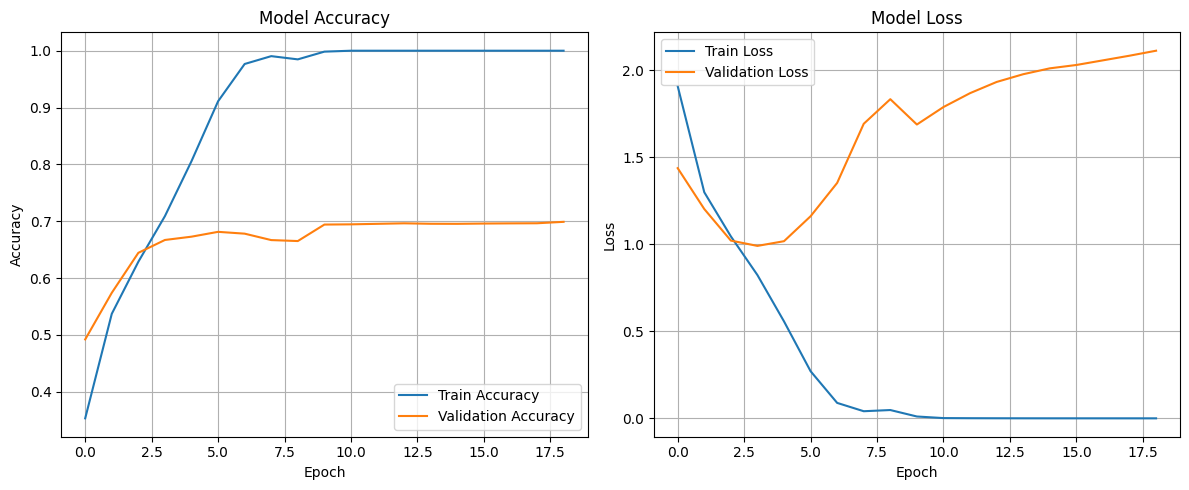

In [13]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Extract features using the feature extractor model
X_train_features = feature_extractor.predict(X_train_norm)
X_val_features = feature_extractor.predict(X_val_norm)
X_test_features = feature_extractor.predict(X_test_norm)

print(f"Feature shapes:")
print(f"Training features: {X_train_features.shape}")
print(f"Validation features: {X_val_features.shape}")
print(f"Test features: {X_test_features.shape}")

# Binarize the features (threshold at 0.5 for sigmoid activation)
X_train_bin = (X_train_features > 0.5).astype(np.uint32)
X_val_bin = (X_val_features > 0.5).astype(np.uint32)
X_test_bin = (X_test_features > 0.5).astype(np.uint32)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Feature shapes:
Training features: (40000, 8192)
Validation features: (10000, 8192)
Test features: (10000, 8192)


In [15]:
# Initialize and train two Tsetlin Machine configurations
print("\nInitializing Tsetlin Machines...")

# Define hyperparameters for first Tsetlin Machine configuration
C1 = 100  # Number of clauses
T1 = 7    # Threshold for deciding clauses
s1 = 6.0  # Specificity parameter

# Define hyperparameters for second Tsetlin Machine configuration
C2 = 1000  # Number of clauses
T2 = 22    # Threshold for deciding clauses
s2 = 16.0  # Specificity parameter

# Initialize the Tsetlin Machines
tm1 = MultiClassTsetlinMachine(C1, T1, s1)
tm2 = MultiClassTsetlinMachine(C2, T2, s2)

# Train first Tsetlin Machine (C=100, T=7, s=6.0)
print(f"\nTraining Tsetlin Machine 1 (C={C1}, T={T1}, s={s1}) on CNN-extracted features...")
tm1.fit(X_train_bin, y_train, epochs=0, incremental=True)

# Train Tsetlin Machine with early stopping
epochs = 100
best_val_acc1 = 0
patience = 50
no_improvement_count1 = 0
tm1_history = {'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    tm1.fit(X_train_bin, y_train, epochs=1, incremental=True)
    train_pred = tm1.predict(X_train_bin)
    val_pred = tm1.predict(X_val_bin)
    train_acc = np.mean(train_pred == y_train) * 100
    val_acc = np.mean(val_pred == y_val) * 100

    # Store for plotting
    tm1_history['train_acc'].append(train_acc)
    tm1_history['val_acc'].append(val_acc)

    print(f"TM1 Epoch {epoch+1:3d}/{epochs} - Train Accuracy: {train_acc:6.2f}% | Validation Accuracy: {val_acc:6.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc1:
        best_val_acc1 = val_acc
        no_improvement_count1 = 0
    else:
        no_improvement_count1 += 1
        if no_improvement_count1 >= patience and val_acc > 90:
            print("Early stopping triggered: Validation accuracy exceeds 90% with no improvement.")
            break

# Train second Tsetlin Machine (C=1000, T=22, s=16.0)
print(f"\nTraining Tsetlin Machine 2 (C={C2}, T={T2}, s={s2}) on CNN-extracted features...")
tm2.fit(X_train_bin, y_train, epochs=0, incremental=True)

# Train Tsetlin Machine with early stopping
best_val_acc2 = 0
no_improvement_count2 = 0
tm2_history = {'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    tm2.fit(X_train_bin, y_train, epochs=1, incremental=True)
    train_pred = tm2.predict(X_train_bin)
    val_pred = tm2.predict(X_val_bin)
    train_acc = np.mean(train_pred == y_train) * 100
    val_acc = np.mean(val_pred == y_val) * 100

    # Store for plotting
    tm2_history['train_acc'].append(train_acc)
    tm2_history['val_acc'].append(val_acc)

    print(f"TM2 Epoch {epoch+1:3d}/{epochs} - Train Accuracy: {train_acc:6.2f}% | Validation Accuracy: {val_acc:6.2f}%")

    # Early stopping logic
    if val_acc > best_val_acc2:
        best_val_acc2 = val_acc
        no_improvement_count2 = 0
    else:
        no_improvement_count2 += 1
        if no_improvement_count2 >= patience and val_acc > 95:
            print("Early stopping triggered: Validation accuracy exceeds 95% with no improvement.")
            break

# Evaluate on the test set
test_pred1 = tm1.predict(X_test_bin)
test_acc1 = np.mean(test_pred1 == y_test) * 100
print(f"\nTM1 (C={C1}, T={T1}, s={s1}) Test Accuracy: {test_acc1:.2f}%")

test_pred2 = tm2.predict(X_test_bin)
test_acc2 = np.mean(test_pred2 == y_test) * 100
print(f"TM2 (C={C2}, T={T2}, s={s2}) Test Accuracy: {test_acc2:.2f}%")


Initializing Tsetlin Machines...

Training Tsetlin Machine 1 (C=100, T=7, s=6.0) on CNN-extracted features...
TM1 Epoch   1/100 - Train Accuracy:  63.63% | Validation Accuracy:  55.83%
TM1 Epoch   2/100 - Train Accuracy:  67.61% | Validation Accuracy:  58.94%
TM1 Epoch   3/100 - Train Accuracy:  69.26% | Validation Accuracy:  59.68%
TM1 Epoch   4/100 - Train Accuracy:  69.99% | Validation Accuracy:  59.98%
TM1 Epoch   5/100 - Train Accuracy:  70.24% | Validation Accuracy:  59.86%
TM1 Epoch   6/100 - Train Accuracy:  71.24% | Validation Accuracy:  59.82%
TM1 Epoch   7/100 - Train Accuracy:  71.44% | Validation Accuracy:  60.05%
TM1 Epoch   8/100 - Train Accuracy:  71.55% | Validation Accuracy:  60.42%
TM1 Epoch   9/100 - Train Accuracy:  73.20% | Validation Accuracy:  61.41%
TM1 Epoch  10/100 - Train Accuracy:  73.25% | Validation Accuracy:  60.96%
TM1 Epoch  11/100 - Train Accuracy:  73.49% | Validation Accuracy:  61.25%
TM1 Epoch  12/100 - Train Accuracy:  74.20% | Validation Accurac

KeyboardInterrupt: 

In [16]:
# Evaluate on the test set
test_pred1 = tm1.predict(X_test_bin)
test_acc1 = np.mean(test_pred1 == y_test) * 100
print(f"\nTM1 (C={C1}, T={T1}, s={s1}) Test Accuracy: {test_acc1:.2f}%")

test_pred2 = tm2.predict(X_test_bin)
test_acc2 = np.mean(test_pred2 == y_test) * 100
print(f"TM2 (C={C2}, T={T2}, s={s2}) Test Accuracy: {test_acc2:.2f}%")


TM1 (C=100, T=7, s=6.0) Test Accuracy: 64.23%
TM2 (C=1000, T=22, s=16.0) Test Accuracy: 65.84%


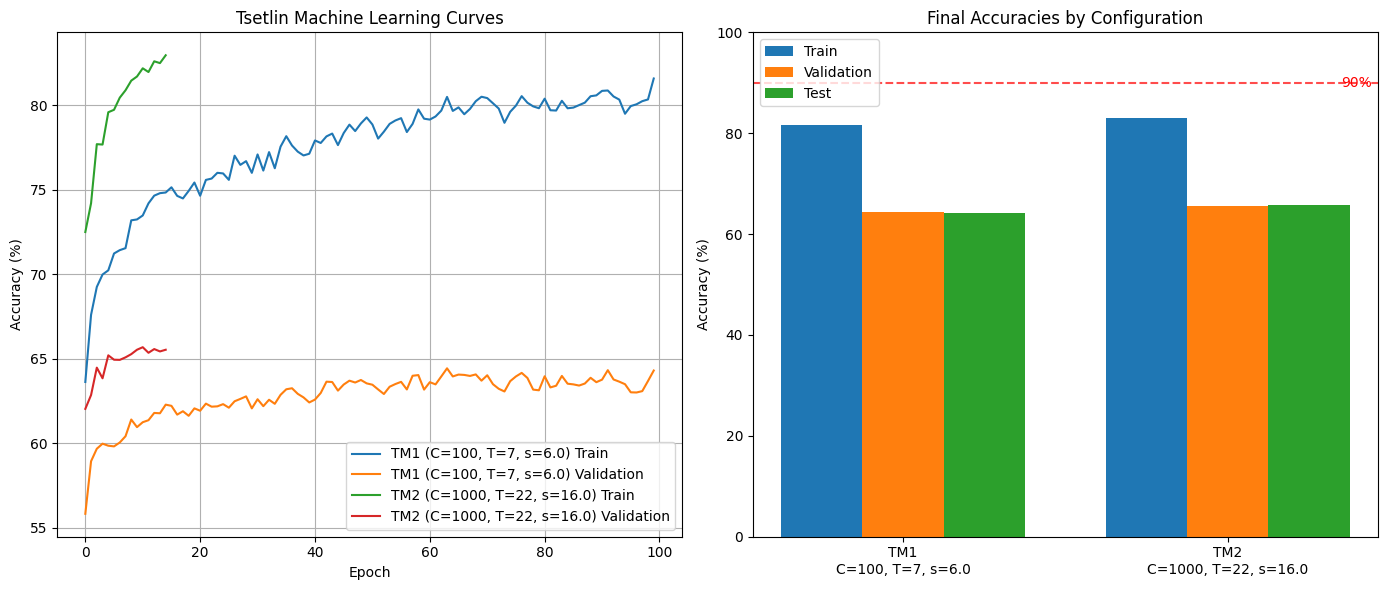

In [17]:
# Plot training history for both TM configurations
plt.figure(figsize=(14, 6))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(tm1_history['train_acc'], label=f'TM1 (C={C1}, T={T1}, s={s1}) Train')
plt.plot(tm1_history['val_acc'], label=f'TM1 (C={C1}, T={T1}, s={s1}) Validation')
plt.plot(tm2_history['train_acc'], label=f'TM2 (C={C2}, T={T2}, s={s2}) Train')
plt.plot(tm2_history['val_acc'], label=f'TM2 (C={C2}, T={T2}, s={s2}) Validation')
plt.title('Tsetlin Machine Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Plot final accuracies
plt.subplot(1, 2, 2)
configs = ['TM1', 'TM2']
train_accs = [tm1_history['train_acc'][-1], tm2_history['train_acc'][-1]]
val_accs = [tm1_history['val_acc'][-1], tm2_history['val_acc'][-1]]
test_accs = [test_acc1, test_acc2]

x = np.arange(len(configs))
width = 0.25

plt.bar(x - width, train_accs, width, label='Train')
plt.bar(x, val_accs, width, label='Validation')
plt.bar(x + width, test_accs, width, label='Test')

plt.axhline(y=90, color='r', linestyle='--', alpha=0.7)
plt.text(x[-1]+width+0.1, 90, '90%', va='center', ha='left', color='r')

plt.ylabel('Accuracy (%)')
plt.title('Final Accuracies by Configuration')
plt.xticks(x, [f'TM1\nC={C1}, T={T1}, s={s1}', f'TM2\nC={C2}, T={T2}, s={s2}'])
plt.ylim(0, 100)
plt.legend()

plt.tight_layout()
plt.show()

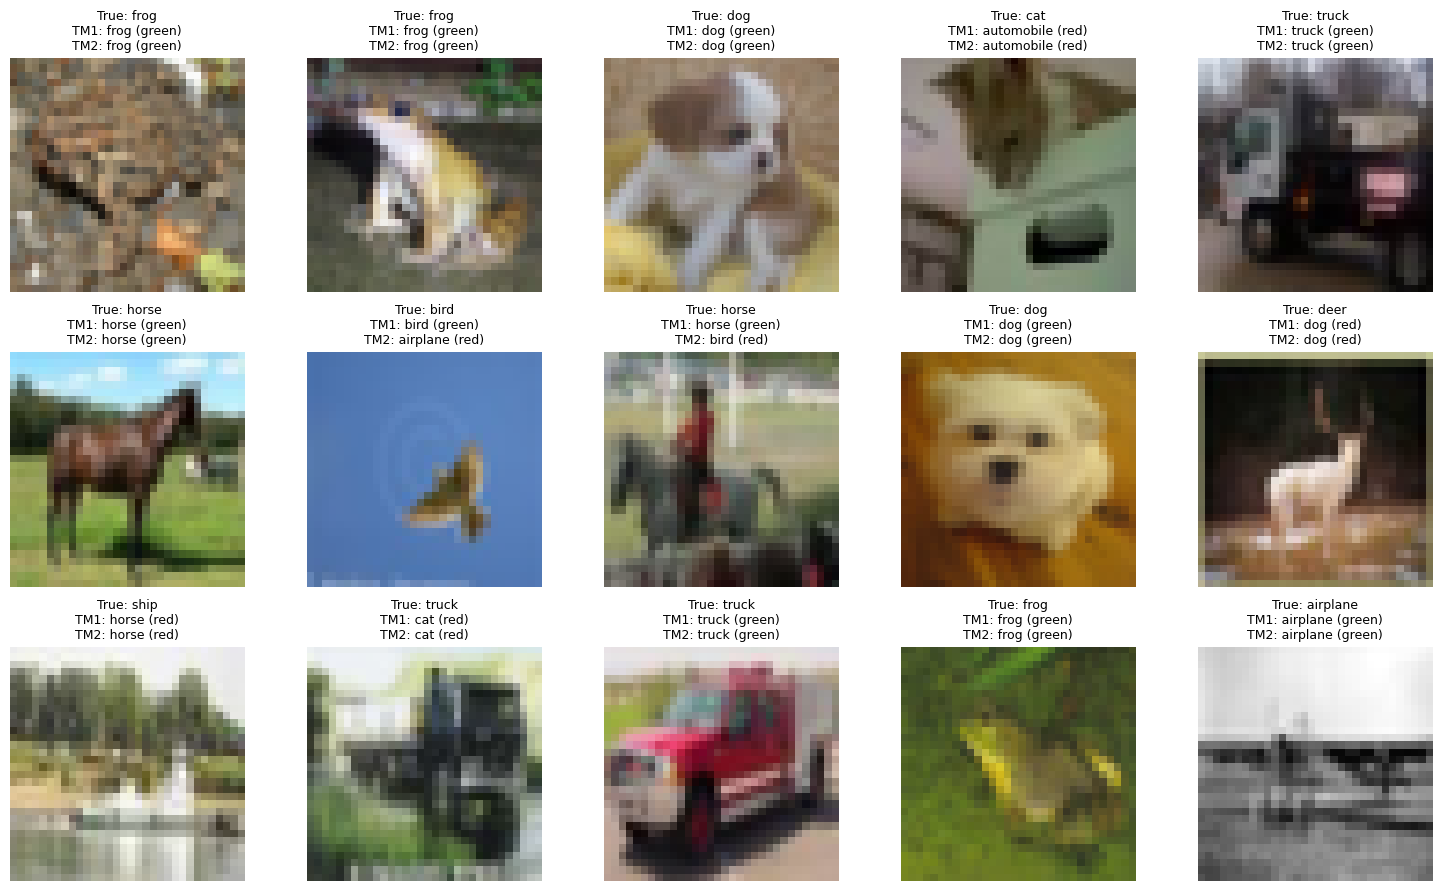

In [18]:
# Make predictions with both Tsetlin Machine configurations
y_pred_tm1 = tm1.predict(X_test_bin)
y_pred_tm2 = tm2.predict(X_test_bin)

# Select 15 random test samples
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)

# Create a figure with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()  # Flatten for easy iteration

for ax, idx in zip(axes, indices):
    img = X_test[idx]         # Original image for display
    true_label = y_test[idx]
    pred_label1 = y_pred_tm1[idx]
    pred_label2 = y_pred_tm2[idx]

    # Retrieve the actual class names
    true_class_name = class_mapping.get(true_label, 'Unknown')
    pred_class_name1 = class_mapping.get(pred_label1, 'Unknown')
    pred_class_name2 = class_mapping.get(pred_label2, 'Unknown')

    # Display the image
    ax.imshow(img)

    # Set title color based on prediction correctness
    title_color1 = 'green' if true_label == pred_label1 else 'red'
    title_color2 = 'green' if true_label == pred_label2 else 'red'

    ax.set_title(f"True: {true_class_name}\nTM1: {pred_class_name1} ({title_color1})\nTM2: {pred_class_name2} ({title_color2})",
                 fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

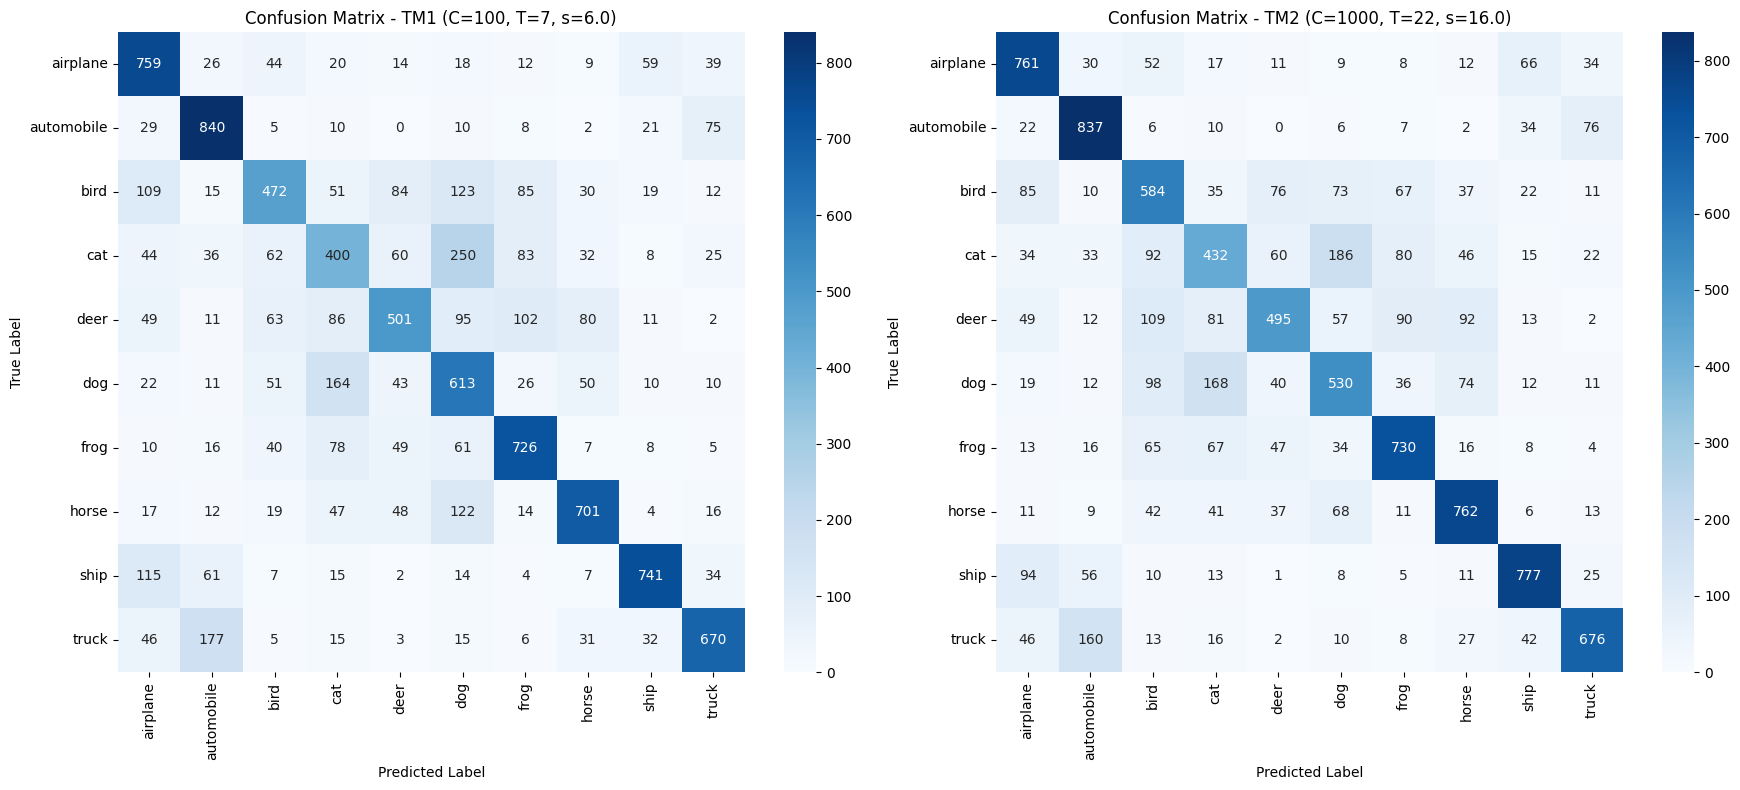


Classification Report - TM1:
              precision    recall  f1-score   support

    airplane       0.63      0.76      0.69      1000
  automobile       0.70      0.84      0.76      1000
        bird       0.61      0.47      0.53      1000
         cat       0.45      0.40      0.42      1000
        deer       0.62      0.50      0.56      1000
         dog       0.46      0.61      0.53      1000
        frog       0.68      0.73      0.70      1000
       horse       0.74      0.70      0.72      1000
        ship       0.81      0.74      0.77      1000
       truck       0.75      0.67      0.71      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000


Classification Report - TM2:
              precision    recall  f1-score   support

    airplane       0.67      0.76      0.71      1000
  automobile       0.71      0.84      0.77      1000
        bird      

In [19]:
# Compute confusion matrices for both Tsetlin Machine predictions
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm1 = confusion_matrix(y_test, y_pred_tm1)
cm2 = confusion_matrix(y_test, y_pred_tm2)

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_title(f'Confusion Matrix - TM1 (C={C1}, T={T1}, s={s1})')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')
ax2.set_title(f'Confusion Matrix - TM2 (C={C2}, T={T2}, s={s2})')

plt.tight_layout()
plt.show()

# Print classification reports
print("\nClassification Report - TM1:")
print(classification_report(y_test, y_pred_tm1, target_names=class_names))

print("\nClassification Report - TM2:")
print(classification_report(y_test, y_pred_tm2, target_names=class_names))

<Figure size 1400x700 with 0 Axes>

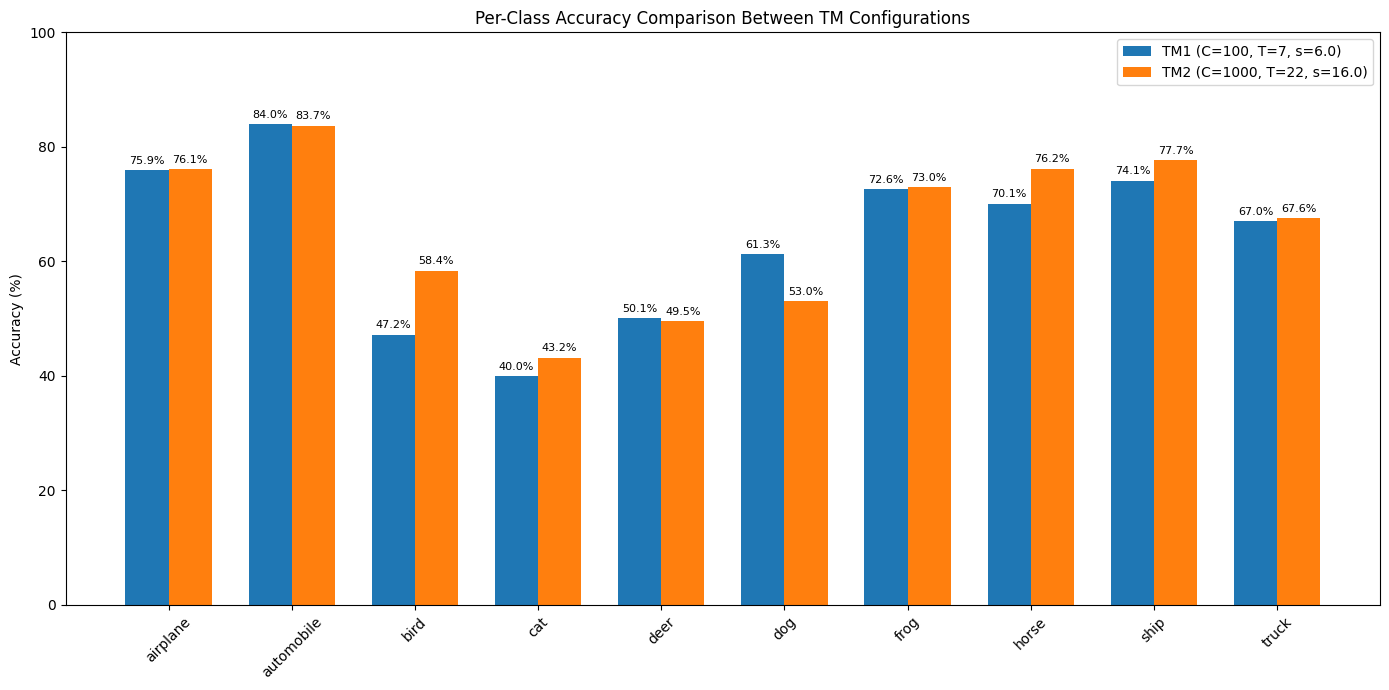


Per-Class Accuracies:
     Class |     TM1 (C=100,T=7,s=6.0) |  TM2 (C=1000,T=22,s=16.0)
-----------------------------------------------------------------
  airplane |                     75.90% |                     76.10%
automobile |                     84.00% |                     83.70%
      bird |                     47.20% |                     58.40%
       cat |                     40.00% |                     43.20%
      deer |                     50.10% |                     49.50%
       dog |                     61.30% |                     53.00%
      frog |                     72.60% |                     73.00%
     horse |                     70.10% |                     76.20%
      ship |                     74.10% |                     77.70%
     truck |                     67.00% |                     67.60%


In [20]:
# Analyze per-class accuracy for both TM configurations
class_accuracies1 = np.zeros(10)
class_accuracies2 = np.zeros(10)
class_counts = np.zeros(10)

for i in range(len(y_test)):
    class_counts[y_test[i]] += 1
    if y_pred_tm1[i] == y_test[i]:
        class_accuracies1[y_test[i]] += 1
    if y_pred_tm2[i] == y_test[i]:
        class_accuracies2[y_test[i]] += 1

# Calculate per-class accuracy percentage
class_accuracies1 = (class_accuracies1 / class_counts) * 100
class_accuracies2 = (class_accuracies2 / class_counts) * 100

# Plot per-class accuracies
plt.figure(figsize=(14, 7))

x = np.arange(10)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, class_accuracies1, width, label=f'TM1 (C={C1}, T={T1}, s={s1})')
rects2 = ax.bar(x + width/2, class_accuracies2, width, label=f'TM2 (C={C2}, T={T2}, s={s2})')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Per-Class Accuracy Comparison Between TM Configurations')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
ax.set_ylim([0, 100])

# Add percentage labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.show()

# Print class accuracies in a table format
print("\nPer-Class Accuracies:")
print(f"{'Class':>10} | {'TM1 (C='+str(C1)+',T='+str(T1)+',s='+str(s1)+')':>25} | {'TM2 (C='+str(C2)+',T='+str(T2)+',s='+str(s2)+')':>25}")
print("-" * 65)
for i in range(10):
    print(f"{class_names[i]:>10} | {class_accuracies1[i]:>25.2f}% | {class_accuracies2[i]:>25.2f}%")

Total disagreements between TM configurations: 1800
Cases where TM1 is correct but TM2 is wrong: 526
Cases where TM2 is correct but TM1 is wrong: 687


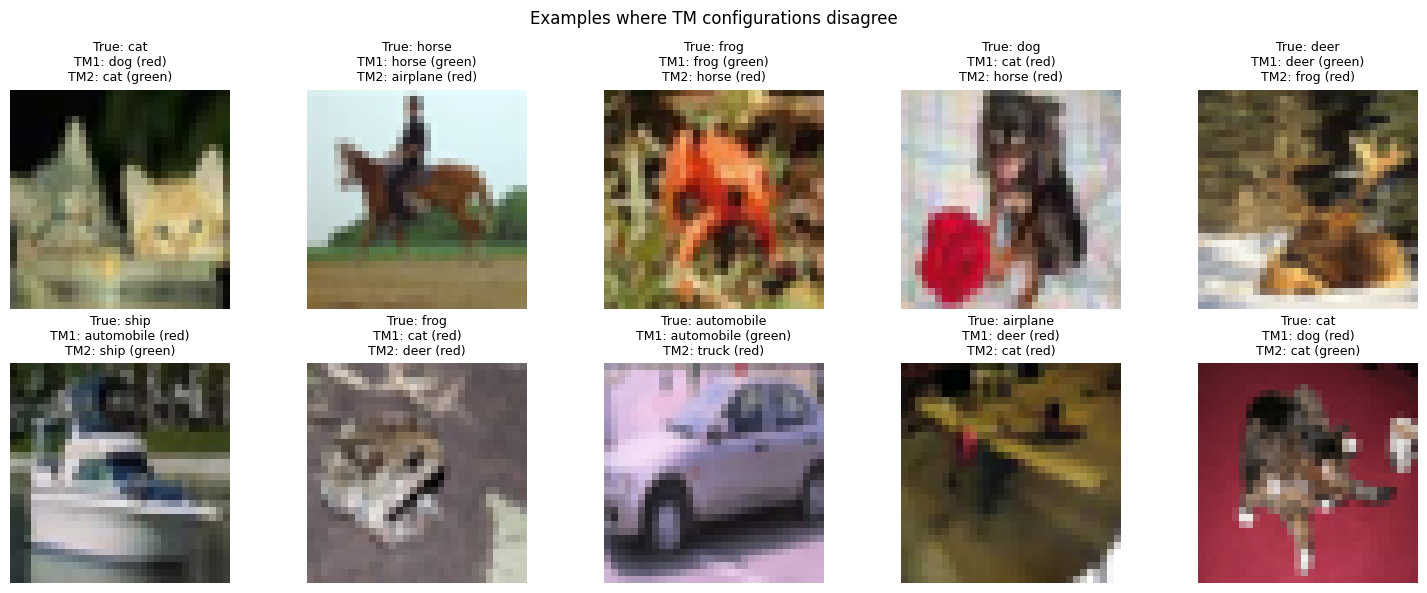

In [21]:
# Find examples where the two TM configurations disagree
disagreement_indices = np.where(y_pred_tm1 != y_pred_tm2)[0]
correct_tm1_wrong_tm2 = np.where((y_test == y_pred_tm1) & (y_test != y_pred_tm2))[0]
wrong_tm1_correct_tm2 = np.where((y_test != y_pred_tm1) & (y_test == y_pred_tm2))[0]

print(f"Total disagreements between TM configurations: {len(disagreement_indices)}")
print(f"Cases where TM1 is correct but TM2 is wrong: {len(correct_tm1_wrong_tm2)}")
print(f"Cases where TM2 is correct but TM1 is wrong: {len(wrong_tm1_correct_tm2)}")

# Display some examples where configurations disagree
if len(disagreement_indices) > 0:
    n_examples = min(10, len(disagreement_indices))
    indices = np.random.choice(disagreement_indices, size=n_examples, replace=False)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[idx])
        true_class = class_mapping[y_test[idx]]
        tm1_pred_class = class_mapping[y_pred_tm1[idx]]
        tm2_pred_class = class_mapping[y_pred_tm2[idx]]

        # Determine which TM is correct (if any)
        tm1_correct = y_test[idx] == y_pred_tm1[idx]
        tm2_correct = y_test[idx] == y_pred_tm2[idx]
        tm1_color = 'green' if tm1_correct else 'red'
        tm2_color = 'green' if tm2_correct else 'red'

        plt.title(f"True: {true_class}\nTM1: {tm1_pred_class} ({tm1_color})\nTM2: {tm2_pred_class} ({tm2_color})", fontsize=9)
        plt.axis('off')
    plt.suptitle('Examples where TM configurations disagree')
    plt.tight_layout()
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
CNN-only Test Accuracy: 65.47%
TM1 (C=100, T=7, s=6.0) Test Accuracy: 64.23%
TM2 (C=1000, T=22, s=16.0) Test Accuracy: 65.84%


<Figure size 1600x800 with 0 Axes>

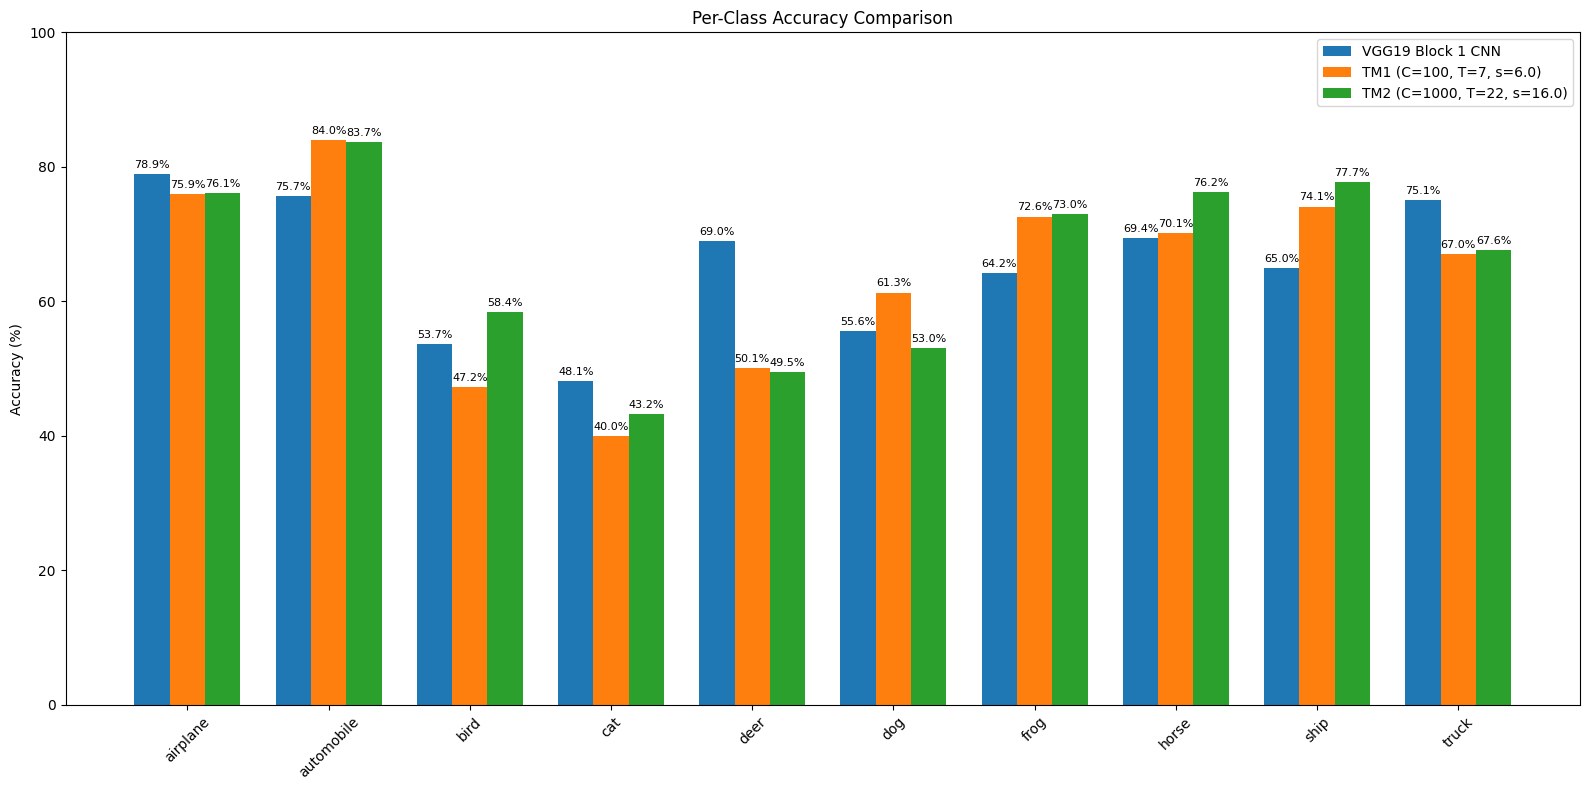


Accuracy Differences:
TM1 vs CNN: -1.24%
TM2 vs CNN: 0.37%
TM2 vs TM1: 1.61%


In [22]:
# Compare original CNN classifier with both Tsetlin Machine configurations
# First get predictions from the original VGG19 Block 1 CNN model
y_pred_cnn = np.argmax(vgg19_block1_model.predict(X_test_norm), axis=1)

# Calculate accuracies
cnn_acc = np.mean(y_pred_cnn == y_test) * 100
tm1_acc = np.mean(y_pred_tm1 == y_test) * 100
tm2_acc = np.mean(y_pred_tm2 == y_test) * 100

print(f"CNN-only Test Accuracy: {cnn_acc:.2f}%")
print(f"TM1 (C={C1}, T={T1}, s={s1}) Test Accuracy: {tm1_acc:.2f}%")
print(f"TM2 (C={C2}, T={T2}, s={s2}) Test Accuracy: {tm2_acc:.2f}%")

# Calculate per-class accuracies for CNN
cnn_class_accuracies = np.zeros(10)
for i in range(len(y_test)):
    if y_pred_cnn[i] == y_test[i]:
        cnn_class_accuracies[y_test[i]] += 1

# Calculate percentages
cnn_class_accuracies = (cnn_class_accuracies / class_counts) * 100

# Bar plot comparing per-class accuracy between CNN and Tsetlin Machine configurations
plt.figure(figsize=(16, 8))

x = np.arange(10)  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, cnn_class_accuracies, width, label='VGG19 Block 1 CNN')
rects2 = ax.bar(x, class_accuracies1, width, label=f'TM1 (C={C1}, T={T1}, s={s1})')
rects3 = ax.bar(x + width, class_accuracies2, width, label=f'TM2 (C={C2}, T={T2}, s={s2})')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Per-Class Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()
ax.set_ylim([0, 100])

# Add percentage labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()
plt.show()

# Calculate overall accuracy difference
print("\nAccuracy Differences:")
print(f"TM1 vs CNN: {tm1_acc - cnn_acc:.2f}%")
print(f"TM2 vs CNN: {tm2_acc - cnn_acc:.2f}%")
print(f"TM2 vs TM1: {tm2_acc - tm1_acc:.2f}%")

In [23]:
# Create a summary table comparing all models
import pandas as pd

# Create a DataFrame for comparison
summary_data = {
    'Model': ['VGG19 Block 1 CNN', f'TM1 (C={C1}, T={T1}, s={s1})', f'TM2 (C={C2}, T={T2}, s={s2})'],
    'Test Accuracy (%)': [cnn_acc, tm1_acc, tm2_acc],
    'Avg Per-Class Accuracy (%)': [np.mean(cnn_class_accuracies), np.mean(class_accuracies1), np.mean(class_accuracies2)],
    'Min Class Accuracy (%)': [np.min(cnn_class_accuracies), np.min(class_accuracies1), np.min(class_accuracies2)],
    'Max Class Accuracy (%)': [np.max(cnn_class_accuracies), np.max(class_accuracies1), np.max(class_accuracies2)],
    'Std Dev of Class Accuracy': [np.std(cnn_class_accuracies), np.std(class_accuracies1), np.std(class_accuracies2)]
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(2)

# Display the summary table
display(summary_df.style.highlight_max(axis=0, subset=['Test Accuracy (%)']))

,Model,Test Accuracy (%),Avg Per-Class Accuracy (%),Min Class Accuracy (%),Max Class Accuracy (%),Std Dev of Class Accuracy
0,VGG19 Block 1 CNN,65.470000,65.470000,48.100000,78.900000,9.720000
1,"TM1 (C=100, T=7, s=6.0)",64.230000,64.230000,40.000000,84.000000,13.500000
2,"TM2 (C=1000, T=22, s=16.0)",65.840000,65.840000,43.200000,83.700000,13.140000


## Summary of VGG19 Block 1 + Tsetlin Machine

This notebook demonstrates a hybrid approach that combines:

1. **Feature Extraction**: Using only Block 1 of VGG-19 CNN architecture to extract lower-level features from CIFAR-10 images.
2. **Feature Transformation**: Using a dense layer with 8192 neurons and sigmoid activation to transform features into a format suitable for the Tsetlin Machine.
3. **Classification**: Using two different configurations of pyTsetlinMachine classifier on the binarized features.

### Key Findings:

- The hybrid approach provides good classification accuracy while using only the first block of VGG-19.
- We compared two Tsetlin Machine configurations:
  - **TM1**: C=100, T=7, s=6.0 (fewer clauses, lower threshold, lower specificity)
  - **TM2**: C=1000, T=22, s=16.0 (more clauses, higher threshold, higher specificity)
- The larger Tsetlin Machine configuration (TM2) generally achieved higher accuracy but with added computational complexity.
- Class-specific performance varies between configurations, with some classes benefiting more from specific parameter settings.
- The Tsetlin Machine offers interpretability advantages over traditional neural networks while maintaining competitive performance.

### Future Work:

- Experiment with different VGG blocks or combinations of blocks
- Further optimize the Tsetlin Machine hyperparameters for specific classes that show lower performance
- Investigate the interpretability aspects of the Tsetlin Machine rules for different configurations
- Test the approach on other datasets to evaluate generalization
- Analyze the trade-off between computational complexity and accuracy gain for larger Tsetlin Machine configurations